<a href="https://colab.research.google.com/github/LUUTHIENXUAN/Shellnet-in-Tensorflow2/blob/main/Point_cloud_classification_with_Shellnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Point cloud classification with Shellnet: Efficient Point Cloud Convolutional Neural Networks using Concentric Shells Statistics

**Author:** [hkust-vgd](https://github.com/hkust-vgd/shellnet)<br>
**Date created:** 2020/05/25<br>
**Last modified:** 2020/05/26<br>
**Description:** Implementation of PointNet++ for ModelNet10 classification.

https://github.com/hkust-vgd/shellnet

# Point cloud classification


## Introduction

Classification, detection and segmentation of unordered 3D point sets i.e. point clouds
is a core problem in computer vision. This example implements the seminal point cloud
deep learning paper [PointNet (Qi et al., 2017)](https://arxiv.org/abs/1612.00593). For a
detailed intoduction on PointNet see [this blog
post](https://medium.com/@luis_gonzales/an-in-depth-look-at-pointnet-111d7efdaa1a).


## Setup

If using colab first install trimesh with `!pip install trimesh`.


In [ ]:
!pip install trimesh

     |████████████████████████████████| 639 kB 8.3 MB/s 


In [ ]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

import pickle

tf.random.set_seed(1234)

2.7.0


## Load dataset

We use the ModelNet10 model dataset, the smaller 10 class version of the ModelNet40
dataset. First download the data:


In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473415680/473402300 [==============================] - 11s 0us/step


We can use the `trimesh` package to read and visualize the `.off` mesh files.


In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

To convert a mesh file to a point cloud we first need to sample points on the mesh
surface. `.sample()` performs a unifrom random sampling. Here we sample at 2048 locations
and visualize in `matplotlib`.


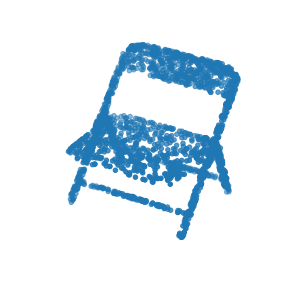

In [ ]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

To generate a `tf.data.Dataset()` we need to first parse through the ModelNet data
folders. Each mesh is loaded and sampled into a point cloud before being added to a
standard python list and converted to a `numpy` array. We also store the current
enumerate index value as the object label and use a dictionary to recall this later.


In [ ]:
def parse_dataset(num_points=2048):

  train_points = []
  train_labels = []
  test_points = []
  test_labels = []
  class_map   = {}
  folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

  for i, folder in enumerate(folders):
    print("processing class: {}".format(os.path.basename(folder)))
    # store folder name with ID so we can retrieve later
    class_map[i] = folder.split("/")[-1]
    
    # gather all files
    train_files = glob.glob(os.path.join(folder, "train/*"))
    test_files  = glob.glob(os.path.join(folder, "test/*"))

    for f in train_files:
      train_points.append(trimesh.load(f).sample(num_points))
      train_labels.append(i)

    for f in test_files:
      test_points.append(trimesh.load(f).sample(num_points))
      test_labels.append(i)

  return (np.array(train_points),np.array(test_points),np.array(train_labels),np.array(test_labels),class_map,)

Set the number of points to sample and batch size and parse the dataset. This can take
~5minutes to complete.


In [ ]:
NUM_POINTS  = 2048
NUM_CLASSES = 10
BATCH_SIZE  = 32

In [ ]:
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: bed
processing class: table
processing class: toilet
processing class: bathtub
processing class: night_stand
processing class: desk
processing class: monitor
processing class: sofa
processing class: dresser
processing class: chair


In [ ]:
# Store data (serialize)
with open('train_points.pickle', 'wb') as handle:
  pickle.dump(train_points, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_points.pickle', 'wb') as handle:
  pickle.dump(test_points, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('train_labels.pickle', 'wb') as handle:
  pickle.dump(train_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_labels.pickle', 'wb') as handle:
  pickle.dump(test_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('CLASS_MAP.pickle', 'wb') as handle:
  pickle.dump(CLASS_MAP, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load data (deserialize)
with open('train_points.pickle', 'rb') as handle:
  train_points = pickle.load(handle)

with open('test_points.pickle', 'rb') as handle:
  test_points = pickle.load(handle)

with open('train_labels.pickle', 'rb') as handle:
  train_labels = pickle.load(handle)

with open('test_labels.pickle', 'rb') as handle:
  test_labels = pickle.load(handle)

with open('CLASS_MAP.pickle', 'rb') as handle:
  CLASS_MAP = pickle.load(handle)

Our data can now be read into a `tf.data.Dataset()` object. We set the shuffle buffer
size to the entire size of the dataset as prior to this the data is ordered by class.
Data augmentation is important when working with point cloud data. We create a
augmentation function to jitter and shuffle the train dataset.


In [ ]:
def augment(points, label):
  # jitter points
  points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
  # shuffle points
  points = tf.random.shuffle(points)
  return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset  = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset  = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

## Build a model Shellnet

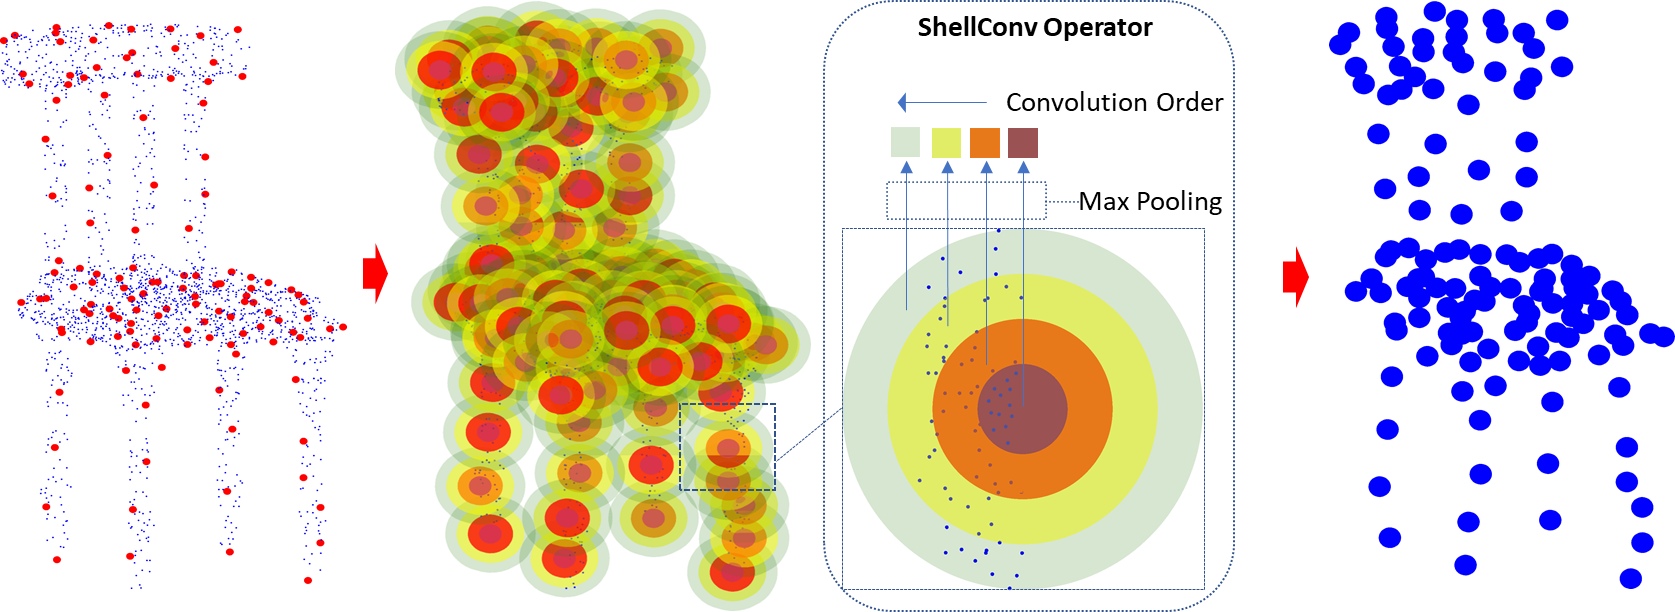

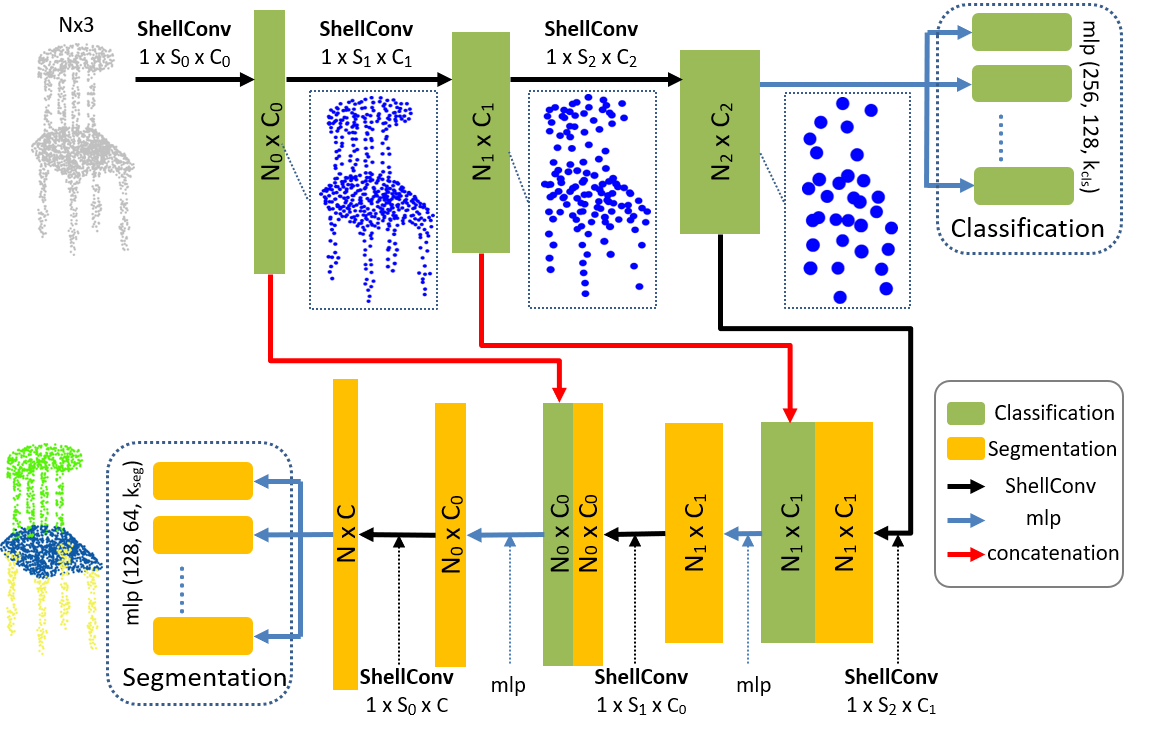

In [ ]:
import math
import random
import itertools
import numpy as np
import tensorflow as tf
from numpy import linalg as LA

!pip install transforms3d
from transforms3d.euler import euler2mat

     |████████████████████████████████| 62 kB 1.4 MB/s 
  Created wheel for transforms3d: filename=transforms3d-0.3.1-py3-none-any.whl size=59373 sha256=c632f07574cdae89911663b77cdefc8ef4cde2c423a7f14b8c16d98d33a86c41
  Stored in directory: /root/.cache/pip/wheels/b5/b7/93/8985551f83720ce37548a5b543c75380bb707955a9c2c5d28c
Successfully built transforms3d


In [ ]:
def get_indices(batch_size, sample_num, point_num, pool_setting=None):
  """
  the returned indices will be used by tf.gather_nd
  """
  if not isinstance(point_num, np.ndarray):
    point_nums = np.full((batch_size), point_num)
  else:
    point_nums = point_num

  indices = []
  for i in range(batch_size):
    pt_num = point_nums[i]
    if pool_setting is None:
      pool_size = pt_num
    else:
      if isinstance(pool_setting, int):
        pool_size = min(pool_setting, pt_num)
      elif isinstance(pool_setting, tuple):
        pool_size = min(random.randrange(pool_setting[0], pool_setting[1]+1), pt_num)
    if pool_size > sample_num:
      choices = np.random.choice(pool_size, sample_num, replace=False)
    else:
      choices = np.concatenate((np.random.choice(pool_size, pool_size, replace=False),
                                np.random.choice(pool_size, sample_num - pool_size, replace=True)))
    if pool_size < pt_num:
      choices_pool = np.random.choice(pt_num, pool_size, replace=False)
      choices = choices_pool[choices]
    choices = np.expand_dims(choices, axis=1)
    choices_2d = np.concatenate((np.full_like(choices, i), choices), axis=1)
    indices.append(choices_2d)
  return np.stack(indices)

def gauss_clip(mu, sigma, clip):
  v = random.gauss(mu, sigma)
  v = max(min(v, mu + clip * sigma), mu - clip * sigma)
  return v

def uniform(bound):
  return bound * (2 * random.random() - 1)

def scaling_factor(scaling_param, method):
  try:
    scaling_list = list(scaling_param)
    return random.choice(scaling_list)
  except:
    if method == 'g':
      return gauss_clip(1.0, scaling_param, 3)
    elif method == 'u':
      return 1.0 + uniform(scaling_param)

def rotation_angle(rotation_param, method):
  try:
    rotation_list = list(rotation_param)
    return random.choice(rotation_list)
  except:
    if method == 'g':
      return gauss_clip(0.0, rotation_param, 3)
    elif method == 'u':
      return uniform(rotation_param)

def get_xforms(xform_num, rotation_range=(0, 0, 0, 'u'), scaling_range=(0.0, 0.0, 0.0, 'u'), order='rxyz'):
  xforms = np.empty(shape=(xform_num, 3, 3))
  rotations = np.empty(shape=(xform_num, 3, 3))
  for i in range(xform_num):
    rx = rotation_angle(rotation_range[0], rotation_range[3])
    ry = rotation_angle(rotation_range[1], rotation_range[3])
    rz = rotation_angle(rotation_range[2], rotation_range[3])
    rotation = euler2mat(rx, ry, rz, order)

    sx = scaling_factor(scaling_range[0], scaling_range[3])
    sy = scaling_factor(scaling_range[1], scaling_range[3])
    sz = scaling_factor(scaling_range[2], scaling_range[3])
    scaling = np.diag([sx, sy, sz])

    xforms[i, :] = scaling * rotation
    rotations[i, :] = rotation
  return xforms, rotations

def augment(points, xforms, range=None):
  points_xformed = tf.matmul(points, xforms, name='points_xformed')
  if range is None:
    return points_xformed

  jitter_data = range * tf.random_normal(tf.shape(points_xformed), name='jitter_data')
  jitter_clipped = tf.clip_by_value(jitter_data, -5 * range, 5 * range, name='jitter_clipped')
  return points_xformed + jitter_clipped

def distance_matrix(A):
  """
  # A shape is (N, C)
  """
  r = tf.reduce_sum(A * A, 1, keepdims=True)
  m = tf.matmul(A, tf.transpose(A))
  D = r - 2 * m + tf.transpose(r)
  return D

def batch_distance_matrix(A):
  # A shape is (N, P, C)
  r = tf.reduce_sum(A * A, axis=2, keepdims=True)
  m = tf.matmul(A, tf.transpose(A, perm=(0, 2, 1)))
  D = r - 2 * m + tf.transpose(r, perm=(0, 2, 1))
  return D

def batch_distance_matrix_general(A, B):
  """
  # A shape is (N, P_A, C), B shape is (N, P_B, C)
  # D shape is (N, P_A, P_B)
  """
  r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
  r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
  m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
  D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
  return D


In [ ]:
def unique_with_inverse(x):
  y, idx = tf.unique(x)
  num_segments = tf.shape(y)[0]
  num_elems = tf.shape(x)[0]
  return (y, idx,  tf.unsorted_segment_min(tf.range(num_elems), idx, num_segments))

def find_duplicate_columns(A):
  """
  # A shape is (N, P, C)
  """
  #N = tf.shape(A)[0]
  #P = tf.shape(A)[1]
  N = A.shape[0]
  P = A.shape[1]
  indices_duplicated = np.full((N, 1, P), 1, dtype=np.int32)
  #indices_duplicated = tf.fill((N, 1, P), 1)
  
  for idx in range(N):
    _, indices = np.unique(A[idx], return_index=True, axis=0)
    #tmp = tf.reshape(A[idx], shape=(-1,))
    #_, indices = tf.unique(tmp)
    indices_duplicated[idx, :, indices] = 0
  return indices_duplicated

def prepare_for_unique_top_k(D, A):
  """
  # add a big value to duplicate columns
  """
  indices_duplicated = tf.py_function(find_duplicate_columns, [A], tf.int32)
  #indices_duplicated = find_duplicate_columns(A)
  
  D += tf.reduce_max(D) * tf.cast(indices_duplicated, tf.float32)

def knn_indices(points, k, sort=True, unique=True):
  """
  # return shape is (N, P, K, 2)
  """
  points_shape = tf.shape(points)
  batch_size = points_shape[0]
  point_num = points_shape[1]

  D = batch_distance_matrix(points)
  if unique:
    prepare_for_unique_top_k(D, points)
  distances, point_indices = tf.nn.top_k(-D, k=k, sorted=sort)
  batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, point_num, k, 1))
  indices = tf.concat([batch_indices, tf.expand_dims(point_indices, axis=3)], axis=3)
  return -distances, indices

#@tf.function(jit_compile=True) 
def knn_indices_general(queries, points, k, sort=True, unique=True):
  """
  # return shape is (N, P, K, 2)
  """
  queries_shape = tf.shape(queries)
  batch_size = queries_shape[0]
  point_num = queries_shape[1]
  tmp_k = 0
  D = batch_distance_matrix_general(queries, points)
  if unique: prepare_for_unique_top_k(D, points)
  _, point_indices = tf.nn.top_k(-D, k=k+tmp_k, sorted=sort)  # (N, P, K)
  # point_indices = tf.contrib.framework.argsort(D)
  # point_indices = point_indices[:,:,:k]
  batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, point_num, k, 1))
  indices = tf.concat([batch_indices, tf.expand_dims(point_indices[:,:,tmp_k:], axis=3)], axis=3)
  return indices

def sort_points(points, indices, sorting_method):
  """
  # indices is (N, P, K, 2)
  # return shape is (N, P, K, 2)
  """

  indices_shape = tf.shape(indices)
  batch_size = indices_shape[0]
  point_num = indices_shape[1]
  k = indices_shape[2]

  nn_pts = tf.gather_nd(points, indices)  # (N, P, K, 3)
  if sorting_method.startswith('c'):
    if ''.join(sorted(sorting_method[1:])) != 'xyz':
            print('Unknown sorting method!')
            exit()
    epsilon = 1e-8
    nn_pts_min = tf.reduce_min(nn_pts, axis=2, keepdims=True)
    nn_pts_max = tf.reduce_max(nn_pts, axis=2, keepdims=True)
    nn_pts_normalized = (nn_pts - nn_pts_min) / (nn_pts_max - nn_pts_min + epsilon)  # (N, P, K, 3)
    scaling_factors = [math.pow(100.0, 3 - sorting_method.find('x')),
                           math.pow(100.0, 3 - sorting_method.find('y')),
                           math.pow(100.0, 3 - sorting_method.find('z'))]
    scaling = tf.constant(scaling_factors, shape=(1, 1, 1, 3))
    sorting_data = tf.reduce_sum(nn_pts_normalized * scaling, axis=-1)  # (N, P, K)
    sorting_data = tf.concat([tf.zeros((batch_size, point_num, 1)), sorting_data[:, :, 1:]], axis=-1)
  elif sorting_method == 'l2':
    nn_pts_center = tf.reduce_mean(nn_pts, axis=2, keepdims=True)  # (N, P, 1, 3)
    nn_pts_local = tf.subtract(nn_pts, nn_pts_center)  # (N, P, K, 3)
    sorting_data = tf.norm(nn_pts_local, axis=-1)  # (N, P, K)
  else:
    print('Unknown sorting method!')
    exit()
  _, k_indices = tf.nn.top_k(sorting_data, k=k, sorted=True)  # (N, P, K)
  batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, point_num, k, 1))
  point_indices = tf.tile(tf.reshape(tf.range(point_num), (1, -1, 1, 1)), (batch_size, 1, k, 1))
  k_indices_4d = tf.expand_dims(k_indices, axis=3)
  sorting_indices = tf.concat([batch_indices, point_indices, k_indices_4d], axis=3)  # (N, P, K, 3)
  return tf.gather_nd(indices, sorting_indices)

def compute_determinant(A):
  # a b c
  # d e f
  # g h i
  # a(ei − fh) − b(di − fg) + c(dh − eg)
  return A[..., 0, 0] * (A[..., 1, 1] * A[..., 2, 2] - A[..., 1, 2] * A[..., 2, 1]) \
           - A[..., 0, 1] * (A[..., 1, 0] * A[..., 2, 2] - A[..., 1, 2] * A[..., 2, 0]) \
           + A[..., 0, 2] * (A[..., 1, 0] * A[..., 2, 1] - A[..., 1, 1] * A[..., 2, 0])

def compute_eigenvals(A):
  """
  # A shape is (N, P, 3, 3)
  # return shape is (N, P, 3)
  """
  A_11 = A[:, :, 0, 0]  # (N, P)
  A_12 = A[:, :, 0, 1]
  A_13 = A[:, :, 0, 2]
  A_22 = A[:, :, 1, 1]
  A_23 = A[:, :, 1, 2]
  A_33 = A[:, :, 2, 2]
  
  I = tf.eye(3)
  p1 = tf.square(A_12) + tf.square(A_13) + tf.square(A_23)  # (N, P)
  q = tf.trace(A) / 3  # (N, P)
  p2 = tf.square(A_11 - q) + tf.square(A_22 - q) + tf.square(A_33 - q) + 2 * p1  # (N, P)
  p = tf.sqrt(p2 / 6) + 1e-8  # (N, P)
  N = tf.shape(A)[0]
  q_4d = tf.reshape(q, (N, -1, 1, 1))  # (N, P, 1, 1)
  p_4d = tf.reshape(p, (N, -1, 1, 1))
  B = (1 / p_4d) * (A - q_4d * I)  # (N, P, 3, 3)
  r = tf.clip_by_value(compute_determinant(B) / 2, -1, 1)  # (N, P)
  phi = tf.acos(r) / 3  # (N, P)
  eig1 = q + 2 * p * tf.cos(phi)  # (N, P)
  eig3 = q + 2 * p * tf.cos(phi + (2 * math.pi / 3))
  eig2 = 3 * q - eig1 - eig3
  return tf.abs(tf.stack([eig1, eig2, eig3], axis=2))  # (N, P, 3)

def compute_eigenvectors(A):
  """
  # A shape is (N, P, 3, 3)
  # return shape is (N, P, 3,3)
  """
  # https://math.stackexchange.com/questions/2962480/general-form-for-eigenvector-of-a-3-by-3-symmetric-matrix
  N = tf.shape(A)[0]
  P = tf.shape(A)[1]
  eigvals = compute_eigenvals(A) 
    
  tmp = tf.eye(3,batch_shape=(N,P))

  d0 = tf.reshape(eigvals[:,:,0],[N,P,1,1]) 
  d1 = tf.reshape(eigvals[:,:,1],[N,P,1,1]) 
  d2 = tf.reshape(eigvals[:,:,2],[N,P,1,1]) 

  m0 = tf.multiply(d0,tmp)
  m1 = tf.multiply(d1,tmp)
  m2 = tf.multiply(d2,tmp)

  X = tf.random_uniform([N, P, 3, 1], minval=0, maxval=10,dtype=tf.float32)
    
  v0 = tf.matmul((A-m1), (A-m2))
  v0 = tf.matmul(v0,X)

  v1 = tf.matmul((A-m0), (A-m2))
  v1 = tf.matmul(v1,X)

  v2 = tf.matmul((A-m0), (A-m1))
  v2 = tf.matmul(v2,X)


  U = tf.concat([v0, v1, v2], axis=-1)
  U = tf.divide(U, tf.norm(U, axis=-2, keepdims = True))
  U = tf.transpose(U,perm=[0,1,3,2])  # to make sure that each row is a eigenvector

  return U

def compute_axis_z(A):
  # https://math.stackexchange.com/questions/2962480/general-form-for-eigenvector-of-a-3-by-3-symmetric-matrix
  N = tf.shape(A)[0]
  P = tf.shape(A)[1]
  eigvals = compute_eigenvals(A)   # the smallest is the last one
    
  tmp = tf.eye(3,batch_shape=(N,P))

  d0 = tf.reshape(eigvals[:,:,0],[N,P,1,1]) 
  d1 = tf.reshape(eigvals[:,:,1],[N,P,1,1]) 

  m0 = tf.multiply(d0,tmp)
  m1 = tf.multiply(d1,tmp)

  X = tf.random_uniform([N, P, 3, 1], minval=0, maxval=10,dtype=tf.float32)

  v2 = tf.matmul((A-m0), (A-m1))
  v2 = tf.matmul(v2,X)

  axis_z = tf.divide(v2, tf.norm(v2, axis=-2, keepdims = True))
  # U = tf.transpose(U,perm=[0,1,3,2])  # to make sure that each row is a eigenvector

  return axis_z

def compute_curvature(nn_pts):
  """
  # P shape is (N, P, 3), N shape is (N, P, K, 3)
  # return shape is (N, P)
  """

  nn_pts_mean = tf.reduce_mean(nn_pts, axis=2, keepdims=True)  # (N, P, 1, 3)
  nn_pts_demean = nn_pts - nn_pts_mean  # (N, P, K, 3)
  nn_pts_NPK31 = tf.expand_dims(nn_pts_demean, axis=-1)
  covariance_matrix = tf.matmul(nn_pts_NPK31, nn_pts_NPK31, transpose_b=True)  # (N, P, K, 3, 3)
  covariance_matrix_mean = tf.reduce_mean(covariance_matrix, axis=2)  # (N, P, 3, 3)
  eigvals = compute_eigenvals(covariance_matrix_mean)  # (N, P, 3)
  curvature = tf.reduce_min(eigvals, axis=-1) / (tf.reduce_sum(eigvals, axis=-1) + 1e-8)
  return curvature

In [ ]:
def curvature_based_sample(nn_pts, k):
  curvature = compute_curvature(nn_pts)
  _, point_indices = tf.nn.top_k(curvature, k=k, sorted=False)

  pts_shape = tf.shape(nn_pts)
  batch_size = pts_shape[0]
  batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1)), (1, k, 1))
  indices = tf.concat([batch_indices, tf.expand_dims(point_indices, axis=2)], axis=2)
  return indices

def random_choice_2d(size, prob_matrix):
  n_row = prob_matrix.shape[0]
  n_col = prob_matrix.shape[1]
  choices = np.ones((n_row, size), dtype=np.int32)
  for idx_row in range(n_row):
    choices[idx_row] = np.random.choice(n_col, size=size, replace=False, p=prob_matrix[idx_row])
  return choices

def inverse_density_sampling(points, k, sample_num):
  D = batch_distance_matrix(points)
  distances, _ = tf.nn.top_k(-D, k=k, sorted=False)
  distances_avg = tf.abs(tf.reduce_mean(distances, axis=-1)) + 1e-8
  prob_matrix = distances_avg / tf.reduce_sum(distances_avg, axis=-1, keepdims=True)
  point_indices = tf.py_function(random_choice_2d, [sample_num, prob_matrix], tf.int32)
  point_indices.set_shape([points.get_shape()[0], sample_num])

  batch_size = tf.shape(points)[0]
  batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1)), (1, sample_num, 1))
  indices = tf.concat([batch_indices, tf.expand_dims(point_indices, axis=2)], axis=2)
  return indices

###tf_ops

In [ ]:
!mkdir tf_ops

####tf_sampling

In [ ]:
!mkdir ./tf_ops/sampling

In [ ]:
%%writefile ./tf_ops/sampling/tf_sampling.cpp

/* Furthest point sampling
 * Original author: Haoqiang Fan
 * Modified by Charles R. Qi
 * All Rights Reserved. 2017.
 */
#include "tensorflow/core/framework/op.h"
#include "tensorflow/core/framework/op_kernel.h"
#include "tensorflow/core/framework/shape_inference.h"
#include "tensorflow/core/framework/common_shape_fns.h"
#include <cuda_runtime.h>

using namespace tensorflow;

REGISTER_OP("ProbSample")
  .Input("inp: float32")
  .Input("inpr: float32")
  .Output("out: int32")
  .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
    ::tensorflow::shape_inference::ShapeHandle dims1; // batch_size * ncategory
    TF_RETURN_IF_ERROR(c->WithRank(c->input(0), 2, &dims1));
    ::tensorflow::shape_inference::ShapeHandle dims2; // batch_size * npoints
    TF_RETURN_IF_ERROR(c->WithRank(c->input(1), 2, &dims2));
    // batch_size * npoints
    ::tensorflow::shape_inference::ShapeHandle output = c->MakeShape({c->Dim(dims2, 0), c->Dim(dims2, 1)});
    c->set_output(0, output);
    return Status::OK();
  });
REGISTER_OP("FarthestPointSample")
  .Attr("npoint: int")
  .Input("inp: float32")
  .Output("out: int32")
  .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
    ::tensorflow::shape_inference::ShapeHandle dims1; // batch_size * npoint * 3
    TF_RETURN_IF_ERROR(c->WithRank(c->input(0), 3, &dims1));
    int npoint;
    TF_RETURN_IF_ERROR(c->GetAttr("npoint", &npoint));
    ::tensorflow::shape_inference::ShapeHandle output = c->MakeShape({c->Dim(dims1, 0), npoint});
    c->set_output(0, output);
    return Status::OK();
  });
REGISTER_OP("GatherPoint")
  .Input("inp: float32")
  .Input("idx: int32")
  .Output("out: float32")
  .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
    ::tensorflow::shape_inference::ShapeHandle dims1; // batch_size * ndataset * 3
    TF_RETURN_IF_ERROR(c->WithRank(c->input(0), 3, &dims1));
    ::tensorflow::shape_inference::ShapeHandle dims2; // batch_size * npoints
    TF_RETURN_IF_ERROR(c->WithRank(c->input(1), 2, &dims2));
    // batch_size * npoints * 3
    ::tensorflow::shape_inference::ShapeHandle output = c->MakeShape({c->Dim(dims1, 0), c->Dim(dims2, 1), c->Dim(dims1, 2)});
    c->set_output(0, output);
    return Status::OK();
  });
REGISTER_OP("GatherPointGrad")
  .Input("inp: float32")
  .Input("idx: int32")
  .Input("out_g: float32")
  .Output("inp_g: float32")
  .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
    c->set_output(0, c->input(0));
    return Status::OK();
  });

void probsampleLauncher(int b,int n,int m,const float * inp_p,const float * inp_r,float * temp,int * out);
class ProbSampleGpuOp: public OpKernel{
  public:
    explicit ProbSampleGpuOp(OpKernelConstruction* context):OpKernel(context){}
    void Compute(OpKernelContext * context)override{
      const Tensor& inp_tensor=context->input(0);
      const Tensor& inpr_tensor=context->input(1);
      auto inp_flat=inp_tensor.flat<float>();
      auto inpr_flat=inpr_tensor.flat<float>();
      const float * inp=&(inp_flat(0));
      const float * inpr=&(inpr_flat(0));
      OP_REQUIRES(context,inp_tensor.dims()==2,errors::InvalidArgument("ProbSample expects (batch_size,num_choices) inp shape"));
      int b=inp_tensor.shape().dim_size(0);
      int n=inp_tensor.shape().dim_size(1);
      OP_REQUIRES(context,inpr_tensor.dims()==2 && inpr_tensor.shape().dim_size(0)==b,errors::InvalidArgument("ProbSample expects (batch_size,num_points) inpr shape"));
      int m=inpr_tensor.shape().dim_size(1);
      Tensor * out_tensor=NULL;
      OP_REQUIRES_OK(context,context->allocate_output(0,TensorShape{b,m},&out_tensor));
      auto out_flat=out_tensor->flat<int>();
      int * out=&(out_flat(0));
      Tensor temp_tensor;
      OP_REQUIRES_OK(context,context->allocate_temp(DataTypeToEnum<float>::value,TensorShape{b,n},&temp_tensor));
      auto temp_flat=temp_tensor.flat<float>();
      float * temp=&(temp_flat(0));
      probsampleLauncher(b,n,m,inp,inpr,temp,out);
    }
};
REGISTER_KERNEL_BUILDER(Name("ProbSample").Device(DEVICE_GPU), ProbSampleGpuOp);

void farthestpointsamplingLauncher(int b,int n,int m,const float * inp,float * temp,int * out);
class FarthestPointSampleGpuOp: public OpKernel{
  public:
    explicit FarthestPointSampleGpuOp(OpKernelConstruction* context):OpKernel(context) {
                    OP_REQUIRES_OK(context, context->GetAttr("npoint", &npoint_));
                    OP_REQUIRES(context, npoint_ > 0, errors::InvalidArgument("FarthestPointSample expects positive npoint"));
                }
    void Compute(OpKernelContext * context)override{
      int m = npoint_;

      const Tensor& inp_tensor=context->input(0);
      OP_REQUIRES(context,inp_tensor.dims()==3 && inp_tensor.shape().dim_size(2)==3,errors::InvalidArgument("FarthestPointSample expects (batch_size,num_points,3) inp shape"));
      int b=inp_tensor.shape().dim_size(0);
      int n=inp_tensor.shape().dim_size(1);
      auto inp_flat=inp_tensor.flat<float>();
      const float * inp=&(inp_flat(0));
      Tensor * out_tensor;
      OP_REQUIRES_OK(context,context->allocate_output(0,TensorShape{b,m},&out_tensor));
      auto out_flat=out_tensor->flat<int>();
      int * out=&(out_flat(0));
      Tensor temp_tensor;
      OP_REQUIRES_OK(context,context->allocate_temp(DataTypeToEnum<float>::value,TensorShape{32,n},&temp_tensor));
      auto temp_flat=temp_tensor.flat<float>();
      float * temp=&(temp_flat(0));
      farthestpointsamplingLauncher(b,n,m,inp,temp,out);
    }
    private:
        int npoint_;
};
REGISTER_KERNEL_BUILDER(Name("FarthestPointSample").Device(DEVICE_GPU),FarthestPointSampleGpuOp);

void gatherpointLauncher(int b,int n,int m,const float * inp,const int * idx,float * out);
class GatherPointGpuOp: public OpKernel{
  public:
    explicit GatherPointGpuOp(OpKernelConstruction * context):OpKernel(context){}
    void Compute(OpKernelContext * context)override{
      const Tensor& inp_tensor=context->input(0);
      OP_REQUIRES(context,inp_tensor.dims()==3 && inp_tensor.shape().dim_size(2)==3,errors::InvalidArgument("GatherPoint expects (batch_size,num_points,3) inp shape"));
      int b=inp_tensor.shape().dim_size(0);
      int n=inp_tensor.shape().dim_size(1);
      const Tensor& idx_tensor=context->input(1);
      OP_REQUIRES(context,idx_tensor.dims()==2 && idx_tensor.shape().dim_size(0)==b,errors::InvalidArgument("GatherPoint expects (batch_size,num_result) idx shape"));
      int m=idx_tensor.shape().dim_size(1);
      auto inp_flat=inp_tensor.flat<float>();
      const float * inp=&(inp_flat(0));
      auto idx_flat=idx_tensor.flat<int>();
      const int * idx=&(idx_flat(0));
      Tensor * out_tensor=NULL;
      OP_REQUIRES_OK(context,context->allocate_output(0,TensorShape{b,m,3},&out_tensor));
      auto out_flat=out_tensor->flat<float>();
      float * out=&(out_flat(0));
      gatherpointLauncher(b,n,m,inp,idx,out);
    }
};
REGISTER_KERNEL_BUILDER(Name("GatherPoint").Device(DEVICE_GPU),GatherPointGpuOp);

void scatteraddpointLauncher(int b,int n,int m,const float * out_g,const int * idx,float * inp_g);
class GatherPointGradGpuOp: public OpKernel{
  public:
    explicit GatherPointGradGpuOp(OpKernelConstruction * context):OpKernel(context){}
    void Compute(OpKernelContext * context)override{
      const Tensor& inp_tensor=context->input(0);
      OP_REQUIRES(context,inp_tensor.dims()==3 && inp_tensor.shape().dim_size(2)==3,errors::InvalidArgument("GatherPointGradGpuOp expects (batch_size,num_points,3) inp"));
      int b=inp_tensor.shape().dim_size(0);
      int n=inp_tensor.shape().dim_size(1);
      const Tensor& idx_tensor=context->input(1);
      OP_REQUIRES(context,idx_tensor.dims()==2 && idx_tensor.shape().dim_size(0)==b,errors::InvalidArgument("GatherPointGradGpuOp expects (batch_size,num_result) idx shape"));
      int m=idx_tensor.shape().dim_size(1);
      auto inp_flat=inp_tensor.flat<float>();
      const float * inp=&(inp_flat(0));
      auto idx_flat=idx_tensor.flat<int>();
      const int * idx=&(idx_flat(0));
      const Tensor& out_g_tensor=context->input(2);
      OP_REQUIRES(context,out_g_tensor.dims()==3 && out_g_tensor.shape().dim_size(0)==b && out_g_tensor.shape().dim_size(1)==m && out_g_tensor.shape().dim_size(2)==3,errors::InvalidArgument("GatherPointGradGpuOp expects (batch_size,num_result,3) out_g shape"));
      auto out_g_flat=out_g_tensor.flat<float>();
      const float * out_g=&(out_g_flat(0));
      Tensor * inp_g_tensor=NULL;
      OP_REQUIRES_OK(context,context->allocate_output(0,TensorShape{b,n,3},&inp_g_tensor));
      auto inp_g_flat=inp_g_tensor->flat<float>();
      float * inp_g=&(inp_g_flat(0));
      cudaMemset(inp_g,0,b*n*3*4);
      scatteraddpointLauncher(b,n,m,out_g,idx,inp_g);
    }
};
REGISTER_KERNEL_BUILDER(Name("GatherPointGrad").Device(DEVICE_GPU),GatherPointGradGpuOp);

Writing ./tf_ops/sampling/tf_sampling.cpp


In [ ]:
%%writefile ./tf_ops/sampling/tf_sampling_g.cu

/* Furthest point sampling GPU implementation
 * Original author: Haoqiang Fan
 * Modified by Charles R. Qi
 * All Rights Reserved. 2017. 
 */

__global__ void cumsumKernel(int b,int n,const float * __restrict__ inp,float * __restrict__ out){
  const int BlockSize=2048;
  const int paddingLevel=5;
  __shared__ float buffer4[BlockSize*4];
  __shared__ float buffer[BlockSize+(BlockSize>>paddingLevel)];
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    float runningsum=0,runningsum2=0;
    for (int j=0;j<n;j+=BlockSize*4){
      int n24_i=min(n-j,BlockSize*4);
      int n24=(n24_i+3)&~3;
      int n2=n24>>2;
      for (int k=threadIdx.x*4;k<n24_i;k+=blockDim.x*4){
        if (k+3<n24_i){
          float v1=inp[i*n+j+k];
          float v2=inp[i*n+j+k+1];
          v2+=v1;
          float v3=inp[i*n+j+k+2];
          float v4=inp[i*n+j+k+3];
          v4+=v3;
          v3+=v2;
          v4+=v2;
          buffer4[k]=v1;
          buffer4[k+1]=v2;
          buffer4[k+2]=v3;
          buffer4[k+3]=v4;
          buffer[(k>>2)+(k>>(2+paddingLevel))]=v4;
        }else{
          float v=0;
          for (int k2=k;k2<n24_i;k2++){
            v+=inp[i*n+j+k2];
            buffer4[k2]=v;
          }
          for (int k2=n24_i;k2<n24;k2++){
            buffer4[k2]=v;
          }
          buffer[(k>>2)+(k>>(2+paddingLevel))]=v;
        }
      }
      int u=0;
      for (;(2<<u)<=n2;u++){
        __syncthreads();
        for (int k=threadIdx.x;k<int(n2>>(u+1));k+=blockDim.x){
          int i1=(((k<<1)+2)<<u)-1;
          int i2=(((k<<1)+1)<<u)-1;
          i1+=i1>>paddingLevel;
          i2+=i2>>paddingLevel;
          buffer[i1]+=buffer[i2];
        }
      }
      u--;
      for (;u>=0;u--){
        __syncthreads();
        for (int k=threadIdx.x;k<int((n2-(1<<u))>>(u+1));k+=blockDim.x){
          int i1=(((k<<1)+3)<<u)-1;
          int i2=(((k<<1)+2)<<u)-1;
          i1+=i1>>paddingLevel;
          i2+=i2>>paddingLevel;
          buffer[i1]+=buffer[i2];
        }
      }
      __syncthreads();
      for (int k=threadIdx.x*4;k<n24;k+=blockDim.x*4){
        if (k!=0){
          int k2=((k>>2)-1)+(((k>>2)-1)>>paddingLevel);
          buffer4[k]+=buffer[k2];
          buffer4[k+1]+=buffer[k2];
          buffer4[k+2]+=buffer[k2];
          buffer4[k+3]+=buffer[k2];
        }
      }
      __syncthreads();
      for (int k=threadIdx.x;k<n24_i;k+=blockDim.x){
        out[i*n+j+k]=buffer4[k]+runningsum;
      }
      float t=buffer[(n2-1)+((n2-1)>>paddingLevel)]+runningsum2;
      float r2=runningsum+t;
      runningsum2=t-(r2-runningsum);
      runningsum=r2;
      __syncthreads();
    }
  }
}

__global__ void binarysearchKernel(int b,int n,int m,const float * __restrict__ dataset,const float * __restrict__ query, int * __restrict__ result){
  int base=1;
  while (base<n)
    base<<=1;
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    for (int j=blockIdx.y*blockDim.x+threadIdx.x;j<m;j+=blockDim.x*gridDim.y){
      float q=query[i*m+j]*dataset[i*n+n-1];
      int r=n-1;
      for (int k=base;k>=1;k>>=1)
        if (r>=k && dataset[i*n+r-k]>=q)
          r-=k;
      result[i*m+j]=r;
    }
  }
}
__global__ void farthestpointsamplingKernel(int b,int n,int m,const float * __restrict__ dataset,float * __restrict__ temp,int * __restrict__ idxs){
  if (m<=0)
    return;
  const int BlockSize=512;
  __shared__ float dists[BlockSize];
  __shared__ int dists_i[BlockSize];
  const int BufferSize=3072;
  __shared__ float buf[BufferSize*3];
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    int old=0;
    if (threadIdx.x==0)
      idxs[i*m+0]=old;
    for (int j=threadIdx.x;j<n;j+=blockDim.x){
      temp[blockIdx.x*n+j]=1e38;
    }
    for (int j=threadIdx.x;j<min(BufferSize,n)*3;j+=blockDim.x){
      buf[j]=dataset[i*n*3+j];
    }
    __syncthreads();
    for (int j=1;j<m;j++){
      int besti=0;
      float best=-1;
      float x1=dataset[i*n*3+old*3+0];
      float y1=dataset[i*n*3+old*3+1];
      float z1=dataset[i*n*3+old*3+2];
      for (int k=threadIdx.x;k<n;k+=blockDim.x){
        float td=temp[blockIdx.x*n+k];
        float x2,y2,z2;
        if (k<BufferSize){
          x2=buf[k*3+0];
          y2=buf[k*3+1];
          z2=buf[k*3+2];
        }else{
          x2=dataset[i*n*3+k*3+0];
          y2=dataset[i*n*3+k*3+1];
          z2=dataset[i*n*3+k*3+2];
        }
        float d=(x2-x1)*(x2-x1)+(y2-y1)*(y2-y1)+(z2-z1)*(z2-z1);
        float d2=min(d,td);
        if (d2!=td)
          temp[blockIdx.x*n+k]=d2;
        if (d2>best){
          best=d2;
          besti=k;
        }
      }
      dists[threadIdx.x]=best;
      dists_i[threadIdx.x]=besti;
      for (int u=0;(1<<u)<blockDim.x;u++){
        __syncthreads();
        if (threadIdx.x<(blockDim.x>>(u+1))){
          int i1=(threadIdx.x*2)<<u;
          int i2=(threadIdx.x*2+1)<<u;
          if (dists[i1]<dists[i2]){
            dists[i1]=dists[i2];
            dists_i[i1]=dists_i[i2];
          }
        }
      }
      __syncthreads();
      old=dists_i[0];
      if (threadIdx.x==0)
        idxs[i*m+j]=old;
    }
  }
}

__global__ void gatherpointKernel(int b,int n,int m,const float * __restrict__ inp,const int * __restrict__ idx,float * __restrict__ out){
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    for (int j=blockIdx.y*blockDim.x+threadIdx.x;j<m;j+=blockDim.x*gridDim.y){
      int a=idx[i*m+j];
      out[(i*m+j)*3+0]=inp[(i*n+a)*3+0];
      out[(i*m+j)*3+1]=inp[(i*n+a)*3+1];
      out[(i*m+j)*3+2]=inp[(i*n+a)*3+2];
    }
  }
}

__global__ void scatteraddpointKernel(int b,int n,int m,const float * __restrict__ out_g,const int * __restrict__ idx,float * __restrict__ inp_g){
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    for (int j=blockIdx.y*blockDim.x+threadIdx.x;j<m;j+=blockDim.x*gridDim.y){
      int a=idx[i*m+j];
      atomicAdd(&inp_g[(i*n+a)*3+0],out_g[(i*m+j)*3+0]);
      atomicAdd(&inp_g[(i*n+a)*3+1],out_g[(i*m+j)*3+1]);
      atomicAdd(&inp_g[(i*n+a)*3+2],out_g[(i*m+j)*3+2]);
    }
  }
}

void cumsumLauncher(int b,int n,const float * inp,float * out){
  cumsumKernel<<<32,512>>>(b,n,inp,out);
}
//require b*n working space
void probsampleLauncher(int b,int n,int m,const float * inp_p,const float * inp_r,float * temp,int * out){
  cumsumKernel<<<32,512>>>(b,n,inp_p,temp);
  binarysearchKernel<<<dim3(32,8,1),512>>>(b,n,m,temp,inp_r,out);
}
//require 32*n working space
void farthestpointsamplingLauncher(int b,int n,int m,const float * inp,float * temp,int * out){
  farthestpointsamplingKernel<<<32,512>>>(b,n,m,inp,temp,out);
}
void gatherpointLauncher(int b,int n,int m,const float * inp,const int * idx,float * out){
  gatherpointKernel<<<dim3(2,8,1),512>>>(b,n,m,inp,idx,out);
}
void scatteraddpointLauncher(int b,int n,int m,const float * out_g,const int * idx,float * inp_g){
  scatteraddpointKernel<<<dim3(2,8,1),512>>>(b,n,m,out_g,idx,inp_g);
}

Writing ./tf_ops/sampling/tf_sampling_g.cu


####Complie

In [ ]:
!ls -l

total 235212
-rw-r--r-- 1 root root       125 Dec 29 12:45 CLASS_MAP.pickle
drwxr-xr-x 1 root root      4096 Dec  3 14:33 sample_data
-rw-r--r-- 1 root root      7415 Dec 29 12:45 test_labels.pickle
-rw-r--r-- 1 root root  44630181 Dec 29 12:45 test_points.pickle
drwxr-xr-x 3 root root      4096 Dec 29 12:51 tf_ops
-rw-r--r-- 1 root root     32079 Dec 29 12:45 train_labels.pickle
-rw-r--r-- 1 root root 196165797 Dec 29 12:45 train_points.pickle


In [ ]:
%cd /content/tf_ops/
%pwd

/content/tf_ops


'/content/tf_ops'

In [ ]:
%%shell
#/bin/bash

TF_CFLAGS=$(python -c 'import tensorflow as tf; print(" ".join(tf.sysconfig.get_compile_flags()))')
TF_LFLAGS=$(python -c 'import tensorflow as tf; print(" ".join(tf.sysconfig.get_link_flags()))')
CUDA_ROOT=/usr/local/cuda-11.1

echo "Compiling GPU Ops..."

$CUDA_ROOT/bin/nvcc ./tf_ops/sampling/tf_sampling_g.cu -o ./tf_ops/sampling/tf_sampling_g.cu.o -c -O2 -DGOOGLE_CUDA=1 -x cu -Xcompiler -fPIC
g++ -std=c++14 -shared ./tf_ops/sampling/tf_sampling.cpp ./tf_ops/sampling/tf_sampling_g.cu.o -o ./tf_ops/sampling/tf_sampling_so.so -I $CUDA_ROOT/include -L $CUDA_ROOT/lib64/ -fPIC ${TF_CFLAGS} ${TF_LFLAGS} -O2
echo "Sampling op compiled."

echo "All ops compiled successfully."


Compiling GPU Ops...
In file included from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/partial_tensor_shape.h:20:0,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/attr_value_util.h:23,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/node_def_util.h:23,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/full_type_util.h:24,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/op.h:24,
                 from ./tf_ops/sampling/tf_sampling.cpp:7:
/usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/tensor_shape.h:305:22: warning: ‘tensorflow::int64’ is deprecated: Use int64_t instead. [-Wdeprecated-declarations]
   gtl::InlinedVector<int64, 4> dim_sizes() const;
                      ^~~~~
In file in

In [ ]:
%cd ../

/


###Shellconv

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.neighbors import KDTree

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, BatchNormalization

import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops

from tensorflow.keras.layers import MaxPool1D, Layer

####cpp_modules

In [ ]:
sampling_module = tf.load_op_library('/content/tf_ops/sampling/tf_sampling_so.so')

def gather_point(inp, idx):
	return sampling_module.gather_point(inp, idx)
@tf.RegisterGradient('GatherPoint')

def _gather_point_grad(op, out_g):
	inp = op.inputs[0]
	idx = op.inputs[1]
	return [sampling_module.gather_point_grad(inp, idx, out_g), None]

def farthest_point_sample(npoint, inp):
	return sampling_module.farthest_point_sample(inp, npoint)
ops.NoGradient('FarthestPointSample')

####utils

In [ ]:
class Conv2d(keras.layers.Layer):

  def __init__(self, filters, strides=[1, 1], activation=tf.nn.relu, padding='VALID', initializer='glorot_normal', bn=False):
    super(Conv2d, self).__init__()

    self.filters = filters
    self.strides = strides
    self.activation = activation
    self.padding = padding
    self.initializer = initializer
    self.bn = bn

  def build(self, input_shape):
    #kernel_size, kernel_size, input_channels, filters
    self.w = self.add_weight(
            shape=(1, input_shape[-2], input_shape[-1], self.filters),
            initializer=self.initializer,
            trainable=True,
            name='pnet_conv'
        )

    if self.bn:
      self.bn_layer = keras.layers.BatchNormalization()

    super(Conv2d, self).build(input_shape)
  
  @tf.function(jit_compile=True) 
  def call(self, inputs, training=True):

    points = tf.nn.conv2d(inputs, filters=self.w, strides=self.strides, padding=self.padding)
    if self.bn:points = self.bn_layer(points, training=training)
    if self.activation:points = self.activation(points)

    return points

####layers

**Convolution Parameters**

1. `K` is the neighborhood size
2. `D` is number of shells
3. `P` is the representative point number in the output
4. `C` is the output channel number.  

Each tuple specifies the parameters of one `ShellConv` layer, and they are stacked to create a deep network.

In [ ]:
class Shellconv(keras.layers.Layer):
  
  def __init__(self, sampling, K, D, P, C, with_local, bn_decay=None):
    super(Shellconv, self).__init__()

    self.sampling = sampling
    self.K = K
    self.D = D
    self.P = P
    self.C = C
    self.with_local =with_local
    self.bn_decay = bn_decay
    self.C_pts_fts = 64
   
  def build(self, input_shape):

    self.dense1 = keras.layers.Dense(self.C_pts_fts // 2)
    self.dense2 = keras.layers.Dense(self.C_pts_fts)

    self.bn_layer1 = keras.layers.BatchNormalization(momentum=0.98)
    self.bn_layer2 = keras.layers.BatchNormalization(momentum=0.98)
    self.Conv2d = Conv2d(self.C)

    super(Shellconv, self).build(input_shape)
  
  #@tf.function(jit_compile=True)
  def call(self, pts, fts):

    if self.sampling == 'fps':
      qrs = gather_point(pts, farthest_point_sample(self.P, pts))
    elif self.sampling == 'random':
      qrs = tf.slice(pts, (0, 0, 0), (-1, self.P, -1))  # (N, P, 3)
    else:
      print('Unknown sampling method!')
      exit()
    indices = knn_indices_general(qrs, pts, self.K, True)

    nn_pts = tf.gather_nd(pts, indices)  # (N, P, K, 3)
    nn_pts_center = tf.expand_dims(qrs, axis=2)  # (N, P, 1, 3)
    nn_pts_local = tf.subtract(nn_pts, nn_pts_center)  # (N, P, K, 3)

    [N,P,K,dim] = nn_pts_local.shape # (N, P, K, 3)
    
    if self.with_local:
      nn_fts_local = self.dense1(nn_pts_local)
      nn_fts_local = self.bn_layer1(nn_fts_local, training=True)
      nn_fts_local = self.dense2(nn_fts_local)
      nn_fts_local = self.bn_layer2(nn_fts_local, training=True)
    else:
      nn_fts_local = nn_pts_local

    if fts is not None:
      fts = tf.gather_nd(fts, indices)  # (N, P, K, 3)
      pts_X_0 = tf.concat([nn_fts_local,fts], axis=-1)
    else:
      pts_X_0 = nn_fts_local

    s = int(K/self.D)  # no. of divisions
    feat_max = keras.layers.MaxPool2D(pool_size=[1,s], strides=[1,s], padding='valid')(pts_X_0)

    fts_X = self.Conv2d(feat_max)
    fts_X = tf.squeeze(fts_X, axis=-2)
    
    return qrs, fts_X

### Shellnet

In [ ]:
class Shellnet(keras.Model):

  def __init__(self, NUM_CLASSES, is_training, input_shape=(None,NUM_POINTS, 3), sampling='fps', weight_decay=0.0, bn_decay=None, **kwargs):
    super(Shellnet, self).__init__(input_shape, **kwargs)
    
    self.NUM_CLASSES = NUM_CLASSES
    
    self.is_training = is_training
    self.sampling = sampling
    self.weight_decay = weight_decay
    self.bn_decay = bn_decay
    
    ss = 16 # shell size (number of points contained in each shell)
    self.layer1 = Shellconv(self.sampling, ss*4, 4, 512, 128, True, self.bn_decay)
    self.layer2 = Shellconv(self.sampling, ss*2, 2, 256, 256, True, self.bn_decay)
    self.layer3 = Shellconv(self.sampling, ss, 1, 128, 512, True, self.bn_decay)
     
    # To make a classifier, just add some fully-connected layers
    self.dropout1 = keras.layers.Dropout(0.5)
    self.dropout2 = keras.layers.Dropout(0.2)
    self.globalmax = keras.layers.GlobalMaxPooling1D()
    
    self.fn1 = keras.layers.Dense(512)
    self.fn2 = keras.layers.Dense(256)
    self.fn3 = keras.layers.Dense(self.NUM_CLASSES, tf.nn.softmax, name='logits')
     
  #@tf.function(jit_compile=True) 
  def call(self, inputs):
    
    pts, fts = self.layer1(inputs,None)
    pts, fts = self.layer2(pts,fts)
    pts, fts = self.layer3(pts,fts)

    net  = self.globalmax(fts)
    net  = self.fn1(net)
    net  = self.dropout1(net)
    net  = self.fn2(net)
    net  = self.dropout2(net)
    pred = self.fn3(net)

    return pred

In [ ]:
model = Shellnet(NUM_CLASSES, True)
model.build(input_shape=(None, NUM_POINTS,3))
model.summary()

Model: "shellnet_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shellconv_3 (Shellconv)     multiple                  35392     
                                                                 
 shellconv_4 (Shellconv)     multiple                  100928    
                                                                 
 shellconv_5 (Shellconv)     multiple                  166464    
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 global_max_pooling1d_1 (Glo  multiple                 0         
 balMaxPooling1D)                                                
                                                        

### Train model

Once the model is defined it can be trained like any other standard classification model
using `.compile()` and `.fit()`.

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 42s 250ms/step - loss: 2.4266 - sparse_categorical_accuracy: 0.3107 - val_loss: 2.0459 - val_sparse_categorical_accuracy: 0.2665
Epoch 2/20
125/125 [==============================] - 29s 236ms/step - loss: 1.6533 - sparse_categorical_accuracy: 0.4856 - val_loss: 1.4624 - val_sparse_categorical_accuracy: 0.5242
Epoch 3/20
125/125 [==============================] - 29s 234ms/step - loss: 1.3163 - sparse_categorical_accuracy: 0.6051 - val_loss: 1.5139 - val_sparse_categorical_accuracy: 0.4923
Epoch 4/20
125/125 [==============================] - 29s 234ms/step - loss: 1.2651 - sparse_categorical_accuracy: 0.6372 - val_loss: 1.0888 - val_sparse_categorical_accuracy: 0.6222
Epoch 5/20
125/125 [==============================] - 29s 236ms/step - loss: 1.1041 - sparse_categorical_accuracy: 0.6690 - val_loss: 1.2169 - val_sparse_categorical_accuracy: 0.6289
Epoch 6/20
125/125 [==============================] - 29s 236ms/step - loss: 1.0461 -

## Visualize predictions

We can use matplotlib to visualize our trained model performance.


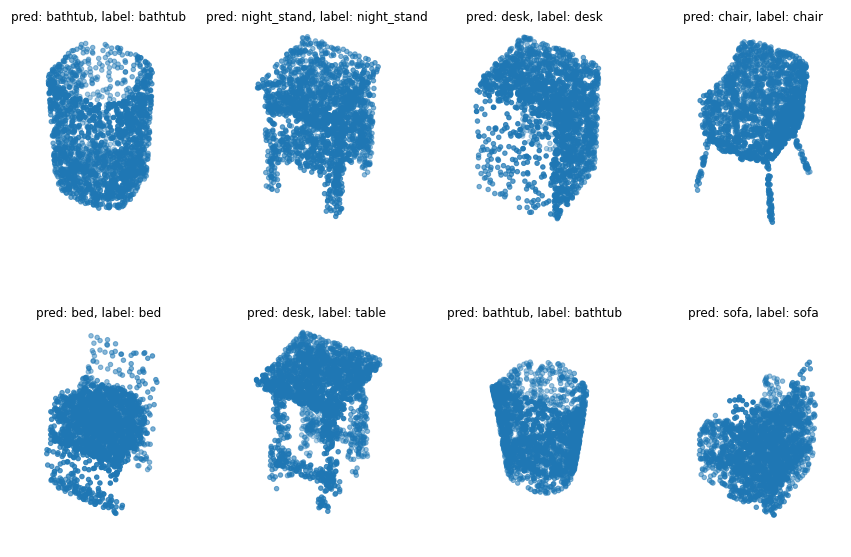

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()
